In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataS.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility']].values    # (T, 1)
y_raw = df[['volatility_forcast']].values  # (T, 1)

# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=1, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.631755
Epoch 2/100 — train MSE: 0.486474
Epoch 3/100 — train MSE: 0.472005
Epoch 4/100 — train MSE: 0.464534
Epoch 5/100 — train MSE: 0.466355
Epoch 6/100 — train MSE: 0.465915
Epoch 7/100 — train MSE: 0.458436
Epoch 8/100 — train MSE: 0.464747
Epoch 9/100 — train MSE: 0.466659
Epoch 10/100 — train MSE: 0.457952
Epoch 11/100 — train MSE: 0.455643
Epoch 12/100 — train MSE: 0.454691
Epoch 13/100 — train MSE: 0.458410
Epoch 14/100 — train MSE: 0.458902
Epoch 15/100 — train MSE: 0.456656
Epoch 16/100 — train MSE: 0.453426
Epoch 17/100 — train MSE: 0.451478
Epoch 18/100 — train MSE: 0.453356
Epoch 19/100 — train MSE: 0.450052
Epoch 20/100 — train MSE: 0.441840
Epoch 21/100 — train MSE: 0.438301
Epoch 22/100 — train MSE: 0.432657
Epoch 23/100 — train MSE: 0.428203
Epoch 24/100 — train MSE: 0.434037
Epoch 25/100 — train MSE: 0.425939
Epoch 26/100 — train MSE: 0.422107
Epoch 27/100 — train MSE: 0.420574
Epoch 28/100 — train MSE: 0.420146
Epoch 29/100 — train MSE: 0.4

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataS.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['Open', 'volatility', 'High', 'Close', 'Volume', 'returns']].values    # (T, 1)
y_raw = df[['volatility_forcast']].values  # (T, 1)

# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=6, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.570874
Epoch 2/100 — train MSE: 0.448353
Epoch 3/100 — train MSE: 0.437192
Epoch 4/100 — train MSE: 0.426167
Epoch 5/100 — train MSE: 0.429001
Epoch 6/100 — train MSE: 0.413881
Epoch 7/100 — train MSE: 0.403900
Epoch 8/100 — train MSE: 0.407021
Epoch 9/100 — train MSE: 0.405712
Epoch 10/100 — train MSE: 0.389630
Epoch 11/100 — train MSE: 0.391313
Epoch 12/100 — train MSE: 0.377871
Epoch 13/100 — train MSE: 0.380053
Epoch 14/100 — train MSE: 0.377045
Epoch 15/100 — train MSE: 0.370822
Epoch 16/100 — train MSE: 0.362296
Epoch 17/100 — train MSE: 0.358136
Epoch 18/100 — train MSE: 0.355530
Epoch 19/100 — train MSE: 0.344084
Epoch 20/100 — train MSE: 0.353001
Epoch 21/100 — train MSE: 0.341097
Epoch 22/100 — train MSE: 0.343328
Epoch 23/100 — train MSE: 0.339496
Epoch 24/100 — train MSE: 0.331059
Epoch 25/100 — train MSE: 0.329563
Epoch 26/100 — train MSE: 0.324221
Epoch 27/100 — train MSE: 0.322004
Epoch 28/100 — train MSE: 0.316817
Epoch 29/100 — train MSE: 0.3

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['Open', 'volatility', 'High', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)

# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=8, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.237846
Epoch 2/100 — train MSE: 0.152824
Epoch 3/100 — train MSE: 0.144139
Epoch 4/100 — train MSE: 0.142260
Epoch 5/100 — train MSE: 0.140906
Epoch 6/100 — train MSE: 0.141080
Epoch 7/100 — train MSE: 0.139337
Epoch 8/100 — train MSE: 0.138074
Epoch 9/100 — train MSE: 0.137432
Epoch 10/100 — train MSE: 0.137630
Epoch 11/100 — train MSE: 0.137759
Epoch 12/100 — train MSE: 0.136871
Epoch 13/100 — train MSE: 0.136728
Epoch 14/100 — train MSE: 0.136963
Epoch 15/100 — train MSE: 0.136588
Epoch 16/100 — train MSE: 0.135684
Epoch 17/100 — train MSE: 0.135676
Epoch 18/100 — train MSE: 0.136752
Epoch 19/100 — train MSE: 0.134694
Epoch 20/100 — train MSE: 0.136118
Epoch 21/100 — train MSE: 0.134417
Epoch 22/100 — train MSE: 0.133894
Epoch 23/100 — train MSE: 0.132313
Epoch 24/100 — train MSE: 0.131941
Epoch 25/100 — train MSE: 0.132021
Epoch 26/100 — train MSE: 0.132047
Epoch 27/100 — train MSE: 0.130703
Epoch 28/100 — train MSE: 0.130671
Epoch 29/100 — train MSE: 0.1

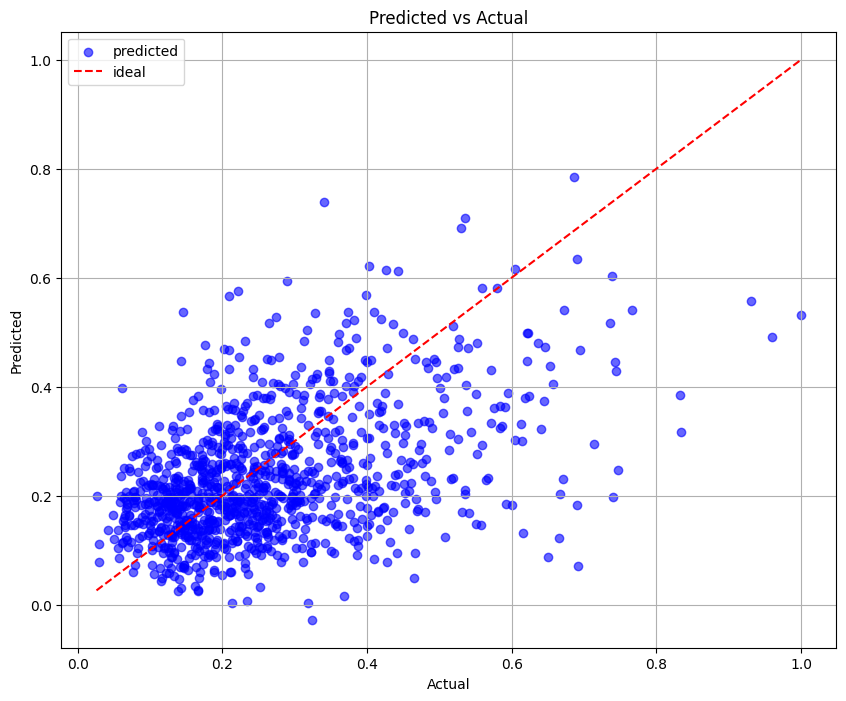

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import os
# Force PyTorch to CPU only (so it won't try to load CUDA libs)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection    import train_test_split
from sklearn.metrics           import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data           import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# Ensure returns exist
if 'returns' not in df.columns:
    df['returns'] = df['Close'].pct_change().fillna(0)

# 2) Rolling targets: mu_t and sigma_t from past 20 returns
SEQ_LEN = 20
df['mu']    = df['returns'].rolling(window=SEQ_LEN).mean().shift(1)
df['sigma'] = df['returns'].rolling(window=SEQ_LEN).std().shift(1)
df['mu_next']    = df['mu'].shift(-1)
df['sigma_next'] = df['sigma'].shift(-1)
df = df.dropna(subset=['mu','sigma','mu_next','sigma_next']).reset_index(drop=True)

# 3) Build features (Close, returns) and targets (mu, sigma)
X_raw = df[['Close','returns','mu','sigma']].values   # now 4 features
y_raw = df[['mu_next','sigma_next']].values            # next‐day as target
# 4) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 5) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)
# X_seq: (N, SEQ_LEN, 2), y_seq: (N, 2)

# 6) Train/test split (80/20, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 7) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).float()
    ),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_test).float(),
        torch.from_numpy(y_test).float()
    ),
    batch_size=batch_size, shuffle=False
)

# 8) Model: LSTM → two outputs (mu, sigma)
class ParamForecast(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc_mu    = nn.Linear(hidden_dim, 1)
        self.fc_sigma = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)           
        h_last = out[:, -1, :]          # (batch, hidden_dim)
        mu     = self.fc_mu(h_last)     
        sigma  = F.softplus(self.fc_sigma(h_last))  # enforce >0
        return mu, sigma

device = torch.device('cpu')
model     = ParamForecast(input_dim=4, hidden_dim=64, num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 9) Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        mu_p, sigma_p = model(Xb)
        y_p = torch.cat([mu_p, sigma_p], dim=1)
        loss = criterion(y_p, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — Train MSE: {running_loss/len(train_loader.dataset):.6f}")

# 10) Evaluation
model.eval()
mu_preds, sigma_preds, y_trues = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        mu_p, sigma_p = model(Xb)
        mu_preds.append(mu_p.cpu().numpy())
        sigma_preds.append(sigma_p.cpu().numpy())
        y_trues.append(yb.numpy())

# Stack and inverse‐scale
mu_pred_sc    = np.vstack(mu_preds)
sigma_pred_sc = np.vstack(sigma_preds)
y_true_sc     = np.vstack(y_trues)

y_pred_all = scaler_y.inverse_transform(
    np.hstack([mu_pred_sc, sigma_pred_sc])
)
y_true_all = scaler_y.inverse_transform(y_true_sc)

mu_pred, sigma_pred = y_pred_all[:,0], y_pred_all[:,1]
mu_true, sigma_true = y_true_all[:,0], y_true_all[:,1]

# 11) Metrics
print("Metrics for μ (mean):")
print("  MSE :", mean_squared_error(mu_true, mu_pred))
print("  MAE :", mean_absolute_error(mu_true, mu_pred))
print("  R2  :", r2_score(mu_true, mu_pred))

print("Metrics for σ (std):")
print("  MSE :", mean_squared_error(sigma_true, sigma_pred))
print("  MAE :", mean_absolute_error(sigma_true, sigma_pred))
print("  R2  :", r2_score(sigma_true, sigma_pred))


Epoch 1/50 — Train MSE: 0.440287
Epoch 2/50 — Train MSE: 0.242558
Epoch 3/50 — Train MSE: 0.203454
Epoch 4/50 — Train MSE: 0.185160
Epoch 5/50 — Train MSE: 0.176686
Epoch 6/50 — Train MSE: 0.171874
Epoch 7/50 — Train MSE: 0.169073
Epoch 8/50 — Train MSE: 0.166419
Epoch 9/50 — Train MSE: 0.165104
Epoch 10/50 — Train MSE: 0.163413
Epoch 11/50 — Train MSE: 0.162219
Epoch 12/50 — Train MSE: 0.162070
Epoch 13/50 — Train MSE: 0.160904
Epoch 14/50 — Train MSE: 0.161750
Epoch 15/50 — Train MSE: 0.158700
Epoch 16/50 — Train MSE: 0.158197
Epoch 17/50 — Train MSE: 0.157480
Epoch 18/50 — Train MSE: 0.156245
Epoch 19/50 — Train MSE: 0.156798
Epoch 20/50 — Train MSE: 0.155593
Epoch 21/50 — Train MSE: 0.155249
Epoch 22/50 — Train MSE: 0.154150
Epoch 23/50 — Train MSE: 0.154142
Epoch 24/50 — Train MSE: 0.152903
Epoch 25/50 — Train MSE: 0.153736
Epoch 26/50 — Train MSE: 0.153717
Epoch 27/50 — Train MSE: 0.152806
Epoch 28/50 — Train MSE: 0.152384
Epoch 29/50 — Train MSE: 0.151341
Epoch 30/50 — Train MSE

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection    import train_test_split
from sklearn.metrics           import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data           import DataLoader, TensorDataset

# 1) Load data
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# Ensure returns column exists
if 'returns' not in df.columns:
    df['returns'] = df['Close'].pct_change().fillna(0)

# 2) Compute rolling mu and sigma from past SEQ_LEN returns
SEQ_LEN = 20
df['mu']    = df['returns'].rolling(window=SEQ_LEN).mean().shift(1)
df['sigma'] = df['returns'].rolling(window=SEQ_LEN).std().shift(1)

# Build next-day deltas
df['mu_next']     = df['mu'].shift(-1)
df['sigma_next']  = df['sigma'].shift(-1)
df['delta_mu']    = df['mu_next'] - df['mu']
df['delta_sigma'] = df['sigma_next'] - df['sigma']

# Drop rows with any NaNs
df = df.dropna(subset=['mu','sigma','delta_mu','delta_sigma']).reset_index(drop=True)

# 3) Features & targets
#   Features: Close, returns, mu, sigma (at time t)
#   Targets:  delta_mu, delta_sigma (for time t→t+1)
X_raw = df[['Close','returns','mu','sigma']].values        # shape (T,4)
y_raw = df[['delta_mu','delta_sigma']].values              # shape (T,2)

# 4) Scale features & targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 5) Build sequences of length SEQ_LEN
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)
# X_seq: (N, SEQ_LEN, 4), y_seq: (N, 2)

# 6) Train/test split (80/20, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 7) Wrap in DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 8) Define LSTM→2-output model
class ParamForecast(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc_mu    = nn.Linear(hidden_dim, 1)
        self.fc_sigma = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)           
        h_last = out[:, -1, :]          
        delta_mu    = self.fc_mu(h_last)
        delta_sigma = self.fc_sigma(h_last)
        return delta_mu, delta_sigma

device = torch.device('cpu')
model     = ParamForecast(input_dim=4, hidden_dim=64, num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 9) Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        mu_p, sigma_p = model(Xb)
        y_pred = torch.cat([mu_p, sigma_p], dim=1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — Train MSE: {epoch_loss:.6f}")

# 10) Evaluation
model.eval()
mu_preds, sigma_preds, y_trues = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        mu_p, sigma_p = model(Xb)
        mu_preds.append(mu_p.cpu().numpy())
        sigma_preds.append(sigma_p.cpu().numpy())
        y_trues.append(yb.numpy())

# Stack and inverse-transform
mu_pred_sc    = np.vstack(mu_preds)
sigma_pred_sc = np.vstack(sigma_preds)
y_true_sc     = np.vstack(y_trues)

y_pred_all = scaler_y.inverse_transform(
    np.hstack([mu_pred_sc, sigma_pred_sc])
)
y_true_all = scaler_y.inverse_transform(y_true_sc)

delta_mu_pred    = y_pred_all[:, 0]
delta_sigma_pred = y_pred_all[:, 1]
delta_mu_true    = y_true_all[:, 0]
delta_sigma_true = y_true_all[:, 1]

# 11) Metrics on deltas
print("Metrics for Δμ:")
print("  MSE :", mean_squared_error(delta_mu_true, delta_mu_pred))
print("  MAE :", mean_absolute_error(delta_mu_true, delta_mu_pred))
print("  R²  :", r2_score(delta_mu_true, delta_mu_pred))

print("Metrics for Δσ:")
print("  MSE :", mean_squared_error(delta_sigma_true, delta_sigma_pred))
print("  MAE :", mean_absolute_error(delta_sigma_true, delta_sigma_pred))
print("  R²  :", r2_score(delta_sigma_true, delta_sigma_pred))


Epoch 1/50 — Train MSE: 0.487504
Epoch 2/50 — Train MSE: 0.457574
Epoch 3/50 — Train MSE: 0.445365
Epoch 4/50 — Train MSE: 0.442019
Epoch 5/50 — Train MSE: 0.437385
Epoch 6/50 — Train MSE: 0.435780
Epoch 7/50 — Train MSE: 0.434781
Epoch 8/50 — Train MSE: 0.429668
Epoch 9/50 — Train MSE: 0.423059
Epoch 10/50 — Train MSE: 0.416607
Epoch 11/50 — Train MSE: 0.399875
Epoch 12/50 — Train MSE: 0.385580
Epoch 13/50 — Train MSE: 0.362935
Epoch 14/50 — Train MSE: 0.332311
Epoch 15/50 — Train MSE: 0.315415
Epoch 16/50 — Train MSE: 0.305760
Epoch 17/50 — Train MSE: 0.293561
Epoch 18/50 — Train MSE: 0.278453
Epoch 19/50 — Train MSE: 0.272030
Epoch 20/50 — Train MSE: 0.258666
Epoch 21/50 — Train MSE: 0.260113
Epoch 22/50 — Train MSE: 0.258110
Epoch 23/50 — Train MSE: 0.249366
Epoch 24/50 — Train MSE: 0.245579
Epoch 25/50 — Train MSE: 0.247573
Epoch 26/50 — Train MSE: 0.239797
Epoch 27/50 — Train MSE: 0.238544
Epoch 28/50 — Train MSE: 0.236031
Epoch 29/50 — Train MSE: 0.232275
Epoch 30/50 — Train MSE

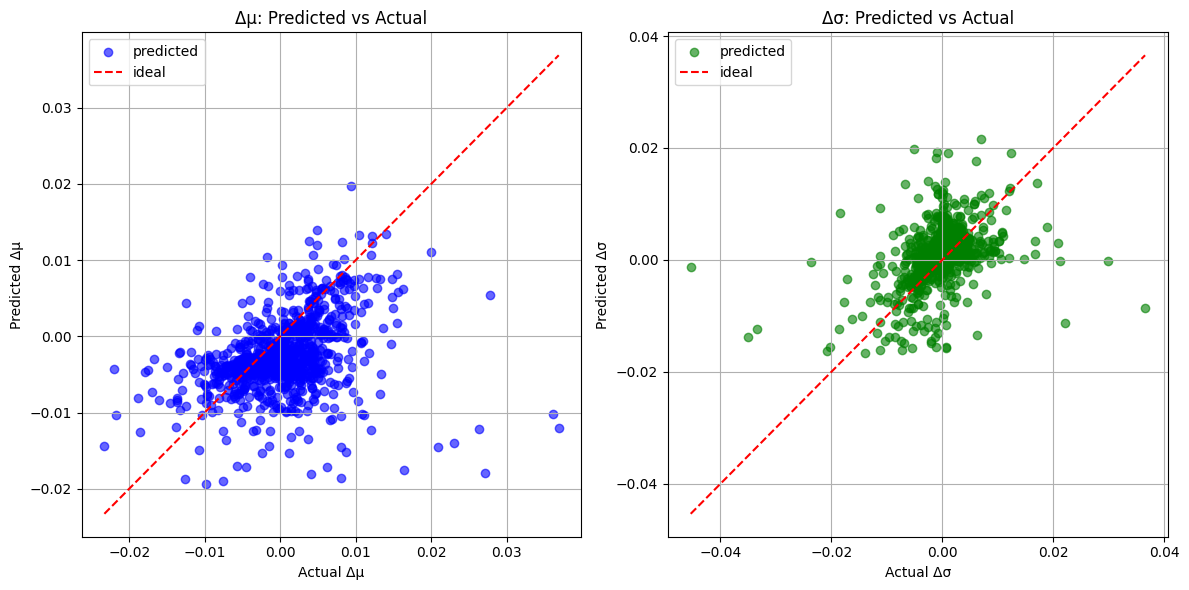

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Δμ subplot
ax = axes[0]
ax.scatter(delta_mu_true, delta_mu_pred,
           alpha=0.6, color='blue', label="predicted")
mn, mx = min(delta_mu_true.min(), delta_mu_pred.min()), max(delta_mu_true.max(), delta_mu_pred.max())
ax.plot([mn, mx], [mn, mx],
        color='red', linestyle='--', label="ideal")
ax.set_title("Δμ: Predicted vs Actual")
ax.set_xlabel("Actual Δμ")
ax.set_ylabel("Predicted Δμ")
ax.legend()
ax.grid(True)

# Δσ subplot
ax = axes[1]
ax.scatter(delta_sigma_true, delta_sigma_pred,
           alpha=0.6, color='green', label="predicted")
mn, mx = min(delta_sigma_true.min(), delta_sigma_pred.min()), max(delta_sigma_true.max(), delta_sigma_pred.max())
ax.plot([mn, mx], [mn, mx],
        color='red', linestyle='--', label="ideal")
ax.set_title("Δσ: Predicted vs Actual")
ax.set_xlabel("Actual Δσ")
ax.set_ylabel("Predicted Δσ")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
